In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
from imp import reload

import seaborn as sns
sns.set_style("dark")

%matplotlib inline

In [2]:
img_data_path = "../image_data/DIP3E_Original_Images_CH09/"

## 腐蚀

> 形态学的操作是对有色的进行操作（即二值图中的白色），若需要对黑色部分进行形态学的操作，则需要将图像翻转，在操作之后，再将结果反转回来

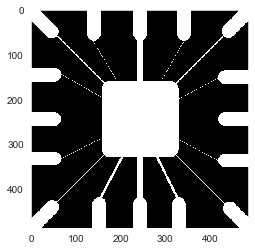

In [24]:
img = Image.open(os.path.join(img_data_path,"Fig0905(a)(wirebond-mask).tif"))
plt.imshow(img)

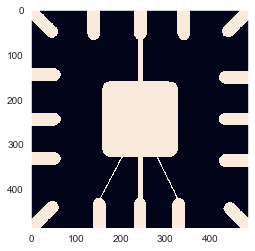

In [21]:
img = np.asarray(img)
img = img.astype(float)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
erode_img = cv2.erode(img,kernel)
plt.imshow(erode_img)

## 膨胀

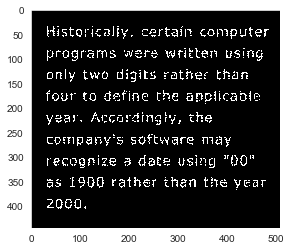

In [23]:
img = Image.open(os.path.join(img_data_path,"Fig0907(a)(text_gaps_1_and_2_pixels).tif"))
plt.imshow(img)

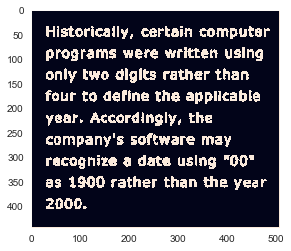

In [24]:
img = np.asarray(img).astype(float)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
dilate_img = cv2.dilate(img,kernel)

plt.imshow(dilate_img)

## 开操作和闭操作

* 开操作： 先腐蚀后膨胀
* 闭操作： 先膨胀后腐蚀

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


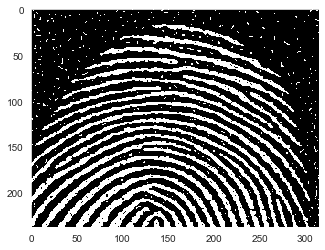

In [284]:
img = Image.open(os.path.join(img_data_path,"Fig0911(a)(noisy_fingerprint).png"))
img = np.asarray(img).astype(float)

plt.imshow(img)

### 开操作

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


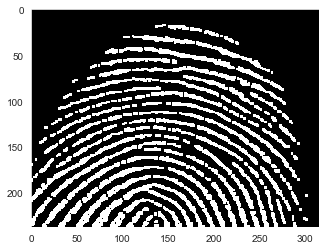

In [285]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))

temp_img = cv2.erode(img,kernel)
temp_img = cv2.dilate(temp_img,kernel)

plt.imshow(temp_img)

### 闭操作

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


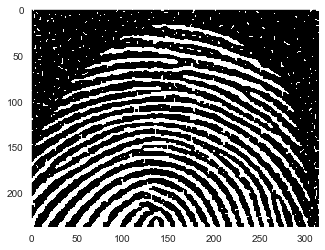

In [286]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))

temp_img = cv2.dilate(img,kernel)
temp_img = cv2.erode(temp_img,kernel)

plt.imshow(temp_img)

## 击中和不击中

### 构造图片

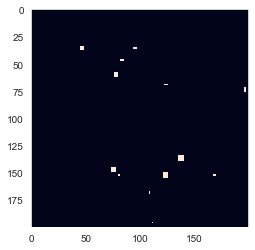

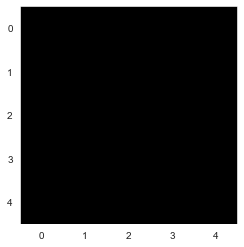

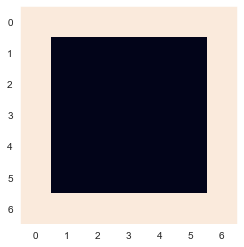

In [4]:
n_shape = 3 # 真集合个数
n_noise = 10 # 噪声个数

img_width,img_height = 200,200 # 图像的长和宽
shape_width,shape_height = 5,5 # 集合的长和宽
n_shape2_extension = 1 # shape2在周围添加的像素点个数
shape_position_list = list() # 保存集合的位置

img = np.zeros(shape = (img_height,img_width)) # 图像

"""构造图形"""
for i in range(n_shape):
    shape_start_x = np.random.randint(0,img_width)
    shape_start_y = np.random.randint(0,img_height)
    
    shape_end_x = shape_start_x + shape_width
    shape_end_y = shape_start_y + shape_height
    
    img[shape_start_y:shape_end_y,shape_start_x:shape_end_x] = 1.
    
    shape_position_x = (shape_start_x + shape_end_x) // 2 
    shape_position_y = (shape_start_y +shape_end_y) // 2
    
    shape_position_list.append((shape_position_y,shape_position_x))
    
"""加噪声"""
for i in range(n_noise):
    start_x = np.random.randint(0,img_width)
    start_y = np.random.randint(0,img_height)
    
    noise_w = np.random.randint(1,shape_width)
    noise_h = np.random.randint(1,shape_height)
    
    noise_end_x,noise_end_y = start_x + noise_w, start_y + noise_h
    img[start_y:noise_end_y,start_x:noise_end_x]  = 1.


shape1 = np.ones(shape=(shape_height,shape_width))
shape1 = shape1.astype(np.uint8)

shape2 = np.zeros((shape_height + n_shape2_extension * 2,shape_width + n_shape2_extension * 2),dtype = int)
shape2[n_shape2_extension:-n_shape2_extension,n_shape2_extension:-n_shape2_extension] = shape1
shape2 = 1 - shape2
shape2 = shape2.astype(np.uint8)


plt.imshow(img)
plt.show()

plt.imshow(shape1,cmap="gray")
plt.show()
plt.imshow(shape2)


### 效果

In [358]:
def hit(img:np.ndarray,shape1:np.ndarray,shape2:np.ndarray):
    """击中"""
    if shape1.dtype != np.uint8 or shape2.dtype != np.uint8:
        raise TypeError
        
    part1 = cv2.erode(img,shape1)
    part2 = cv2.erode(1 - img, shape2)
    
    return np.logical_and((part1 == part2),part1 == 1).astype(int)
    

击中的位置结果:[(37, 20), (73, 116), (171, 182)]
原结果位置：[(37, 20), (73, 116), (171, 182)]


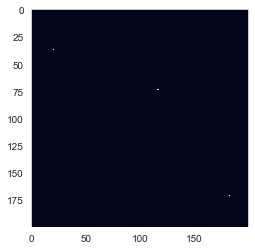

In [367]:
hit_img = hit(img,shape1,shape2)
plt.imshow(hit_img)

hit_position_list = list()
hit_position_tuple = np.where(hit_img == 1)
for i in range(len(hit_position_tuple[0])):
    y = hit_position_tuple[0][i]
    x = hit_position_tuple[1][i]
    
    hit_position_list.append((y,x))
    
print("击中的位置结果:{}".format(sorted(hit_position_list)))
print("原结果位置：{}".format(sorted(shape_position_list)))

## 边界提取

> 边界提取是先用模板对集合A进行腐蚀，而后再执行A和腐蚀结果的集合之差

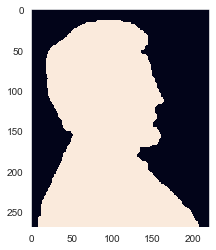

In [20]:
img = Image.open(os.path.join(img_data_path,"Fig0914(a)(licoln from penny).png")).convert("L")
img = np.asarray(img).astype(float)
plt.imshow(img)

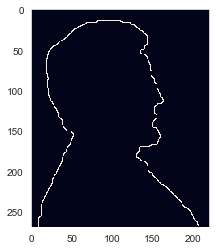

In [21]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))

plt.imshow(img - cv2.erode(img,kernel))

## 连通分量提取

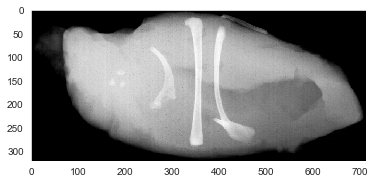

In [42]:
img = Image.open(os.path.join(img_data_path,r"Fig0918(a)(Chickenfilet with bones).tif"))
img = np.asarray(img).astype(float)

plt.imshow(img,cmap = "gray")

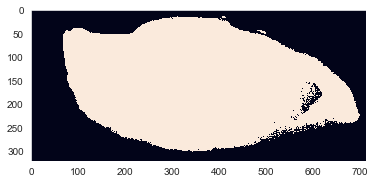

In [47]:
mean_pix = img.mean()
# cv2.threshold()
ret,binary = cv2.threshold(img, mean_pix, 255, cv2.THRESH_BINARY)
plt.imshow(binary)

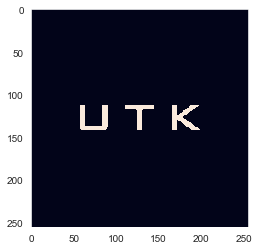

In [211]:
img = Image.open(os.path.join(img_data_path,r"FigP0919(UTK).tif"))
img = np.asarray(img).astype(float)
ret,img = cv2.threshold(img, 127, 1, cv2.THRESH_BINARY)

plt.imshow(img)

In [224]:
def connected_area(img,start_coodination) -> np.ndarray:
    """提取连通分量"""
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
    
    last_temp_img = np.zeros_like(img)
    last_temp_img[start_coodination] = 1
    current_temp_img = cv2.dilate(last_temp_img,kernel)
    
    while (current_temp_img != last_temp_img).any():
        last_temp_img = current_temp_img    
        current_temp_img = cv2.dilate(current_temp_img,kernel)
        current_temp_img = np.logical_and((current_temp_img == img),current_temp_img == 1).astype(float)
    
    return current_temp_img

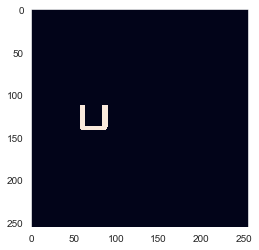

In [225]:
c_img = connected_area(img,(113,57))
c_img = c_img.astype(float)


plt.imshow(c_img)

## 孔洞填充

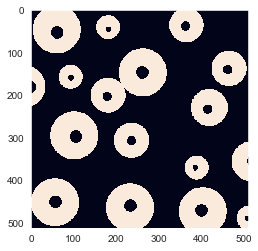

In [244]:
img = Image.open(os.path.join(img_data_path,r"Fig0916(a)(region-filling-reflections).tif"))
img = np.asarray(img).astype(np.float32)
ret,img = cv2.threshold(img, 127, 1, cv2.THRESH_BINARY)

plt.imshow(img)

In [274]:
def blank_fill(img,start_coordination) -> np.ndarray:
    """"""
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(9,9))
    
    last_temp_img = np.zeros_like(img)
    last_temp_img[start_coordination] = 1
    current_temp_img = cv2.dilate(last_temp_img,kernel)
    
    while (current_temp_img != last_temp_img).any():
        last_temp_img = current_temp_img    
        current_temp_img = cv2.dilate(current_temp_img,kernel)

        current_temp_img = np.logical_and(current_temp_img == 1,current_temp_img == (1 - img)).astype(float)
        
    return current_temp_img

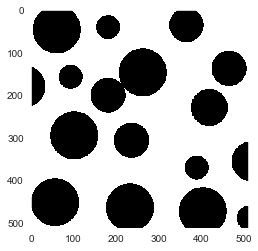

In [281]:
filled_img = blank_fill(img,(0,27))

plt.imshow(filled_img,cmap = "gray")
plt.show()

## 细化

## 形态学重建

### 重建开操作

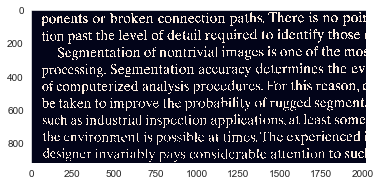

In [35]:
img = Image.open(os.path.join(img_data_path,"Fig0931(a)(text_image).tif"))
img = np.asarray(img).astype(float)

plt.imshow(img)

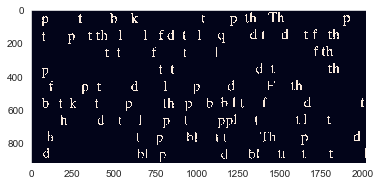

In [37]:
def rebuild_open(img:np.ndarray,kernel:np.ndarray,erode_time:int = 1) -> np.ndarray:
    """
    """
    """多次腐蚀"""
    temp_img = img.copy()
    for i in range(erode_time):
        temp_img = cv2.erode(temp_img,kernel)
        
    """测地膨胀"""
    dialate_kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
    last_img = temp_img.copy()

    while True:
        current_img = cv2.dilate(last_img,dialate_kernel)
        current_img  = np.logical_and(current_img  == 1,current_img == img)
        current_img = current_img.astype(float)
        
        if (current_img ==  last_img).all():
            break
        else:
            last_img = current_img
    
    return current_img


kernel = np.ones(shape=(51,1),dtype=np.uint8)
r = rebuild_open(img,kernel)
plt.imshow(r)


## 灰度形态学

(448, 425)


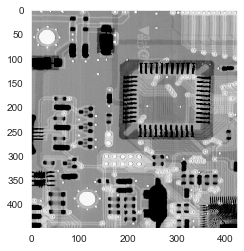

In [44]:
img = Image.open(os.path.join(img_data_path,r"Fig0935(a)(ckt_board_section).tif"))
img = np.asarray(img)
print(img.shape)

plt.imshow(img,cmap = "gray")

### 灰度腐蚀

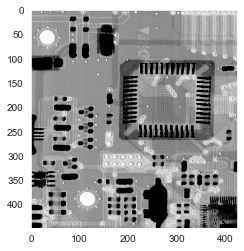

In [48]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(2,2))
new_img = cv2.erode(img,kernel)

plt.imshow(new_img,cmap="gray")

### 灰度膨胀

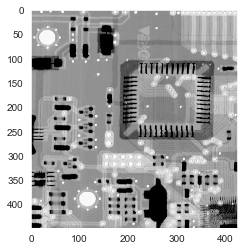

In [49]:
new_img = cv2.dilate(img,kernel)

plt.imshow(new_img, cmap = "gray")

## 开操作

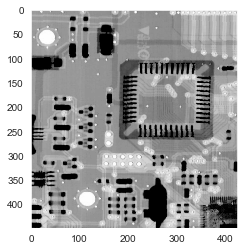

In [53]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
new_img = cv2.morphologyEx(img,cv2.MORPH_OPEN,kernel)
    
plt.imshow(new_img,cmap="gray")

## 灰度闭操作

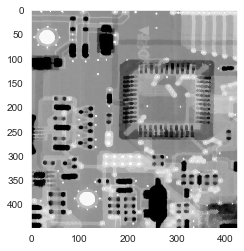

In [54]:
kerenl = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
new_img = cv2.morphologyEx(img, cv2.MORPH_CLOSE,kerenl)

plt.imshow(new_img,cmap="gray")

## 形态学平滑

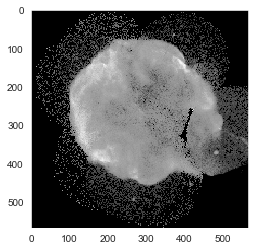

In [57]:
img = Image.open(os.path.join(img_data_path,r"Fig0938(a)(cygnusloop_Xray_original).tif"))
img = np.asarray(img)

plt.imshow(img,cmap = "gray")

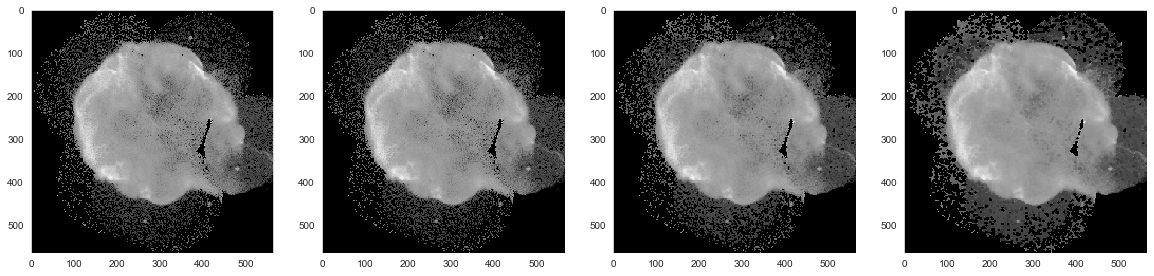

In [62]:
radius_list = [1,3,5]

# _,(ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize = (20,10))
_,ax_list = plt.subplots(1,4,figsize = (20,10))
ax_list[0].imshow(img,cmap="gray")

for i,radius in enumerate(radius_list):
    temp_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(radius,radius))
    temp_img = cv2.morphologyEx(img,cv2.MORPH_OPEN,temp_kernel)
    temp_img = cv2.morphologyEx(img,cv2.MORPH_CLOSE,temp_kernel)
    
    ax_list[i + 1].imshow(temp_img,cmap="gray")
    

## 形态学梯度

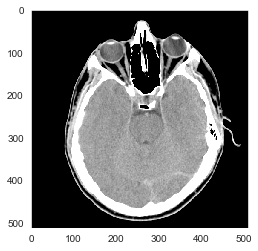

In [63]:
img = Image.open(os.path.join(img_data_path,r"Fig0939(a)(headCT-Vandy).tif"))
img = np.asarray(img)

plt.imshow(img,cmap = "gray")

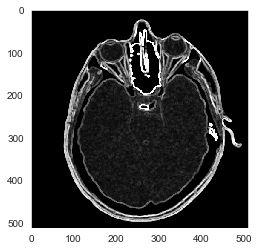

In [65]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))

new_img = cv2.dilate(img,kerenl) - cv2.erode(img,kerenl)
plt.imshow(new_img,cmap = "gray")

## 顶帽

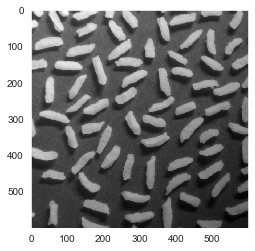

In [67]:
img = Image.open(os.path.join(img_data_path,r"Fig0940(a)(rice_image_with_intensity_gradient).tif"))
img = np.asarray(img)

plt.imshow(img,cmap = "gray")

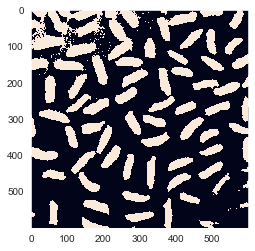

In [76]:
_,a = cv2.threshold(img,127,255,0)

# a = a.astype(float)
plt.imshow(a)

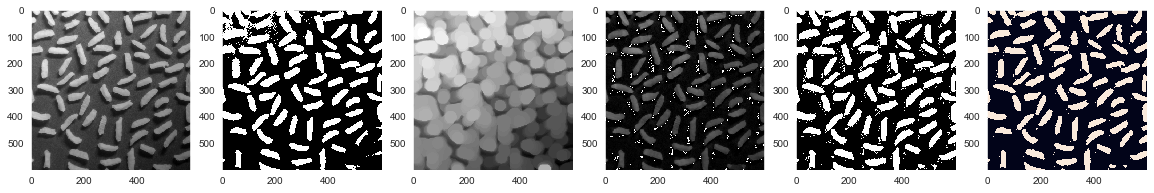

In [165]:
_,ax_list = plt.subplots(1,6,figsize= (20,10))

ax_list[0].imshow(img,cmap = "gray")

_,new_img = cv2.threshold(img,127,255,0)
ax_list[1].imshow(new_img,cmap = "gray")

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(40,40))
new_img = cv2.morphologyEx(img,cv2.MORPH_OPEN,kernel)
# new_img = cv2.erode(img,kerenl)
# new_img = cv2.dilate(new_img,kerenl)
ax_list[2].imshow(new_img,cmap = "gray")

new_img = img - new_img
# new_img = img - new_img
ax_list[3].imshow(new_img,cmap = "gray")

_,new_img = cv2.threshold(new_img,new_img.mean(),255,0)
# new_img = cv2.Canny(new_img,50,150)
ax_list[4].imshow(new_img,cmap = "gray")

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
new_img = cv2.erode(new_img,kernel)
ax_list[-1].imshow(new_img)

## 纹理分割

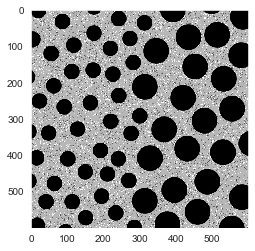

In [167]:
img = Image.open(os.path.join(img_data_path,r"Fig0943(a)(dark_blobs_on_light_background).tif"))
img = np.asarray(img)
plt.imshow(img,cmap = "gray")

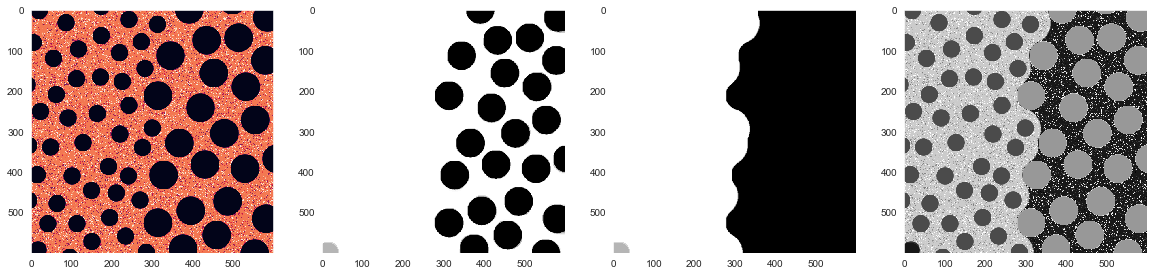

In [187]:
_,ax_list = plt.subplots(1,4,figsize = (20,10))

ax_list[0].imshow(img)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(50,50))
new_img = cv2.morphologyEx(img,cv2.MORPH_CLOSE,kernel)
ax_list[1].imshow(new_img,cmap="gray")

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(100,100))
new_img = cv2.morphologyEx(new_img,cv2.MORPH_OPEN,kernel)
ax_list[2].imshow(new_img,cmap = "gray")

ax_list[3].imshow(new_img +img,cmap =  "gray")